# AB Model


*   Take the train dataset generated from the 4 way self ensemble training and train a multi choice model with only 2 options
*   Use Huggingface transformers: BertForMultipleChoice
*   Will preprocess and batch the text
*   Evaluate results



### Step 1: File set up. 

In [ ]:
#Mount my drive so that I can access the split training sets. 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#copy the training data to colab

%cp -R /content/drive/My\ Drive/train_AB.csv /content/
%cp -R /content/drive/My\ Drive/dev_AB.csv /content/


### Step 2: Set up GPU and HuggingFace

In [ ]:
# Connect to GPU
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: Tesla P100-PCIE-16GB


In [ ]:
!pip install transformers

### Step 3: Load Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('train_AB.csv')
#the empty choice is converted to a NaN when I reload, so this will correct the issue.
df['a'].fillna("", inplace=True)
df['b'].fillna("_padding_", inplace=True)

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# mini_df = df.iloc[0:1000]
# mini_df

Number of training sentences: 130,319



In [ ]:
# ------ FOR A MINI TRAINING SET ------

# #Get the lists of sentences and their labels.
# contexts = mini_df.context.values
# questions = mini_df.question.values
# choices = mini_df[['a','b']].values
# #now converted to an INT
# mini_df.correct_index = mini_df.correct_index.fillna(0)
# labels = mini_df.correct_index.astype(int).values


# ------ FOR THE FULL  TRAINING SET ------
contexts = df.context.values
questions = df.question.values
choices = df[['a','b']].values
#now converted to an INT
df.correct_index = df.correct_index.fillna(0)
labels = df.correct_index.astype(int).values

print(labels.shape)
#print(torch.tensor(labels).unsqueeze(0))

(130319,)


### Step 4: Tokenize the Text

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
#Because the question and answer are combined, this may result
#questions with greater than 512 tokens.

max_len = 0
for sent in contexts:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

#Quite a few errors here:  I will have to take the input length to max and truncate. 

Max sentence length:  450


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
choices_features = []

#---- THIS IS THE LOOP TO COMBINE THE QUESTIONS WITH THE CHOICES ----
for i in range(len(questions)):
    row = list(choices[i])
    q_text = str(questions[i])+' '+str(contexts[i])
    temp_list = []
    for choice in row:
      text = (str(choice))
      temp_list.append(text)

    encoded_dict = tokenizer(
                        [q_text,q_text],
                        temp_list,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 384,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',
                        truncation = True)

# #Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
#input_ids = torch.cat(input_ids, dim=0)
input_ids = torch.stack(input_ids)
attention_masks = torch.stack(attention_masks)
labels = torch.tensor(labels).long()

# # Print sentence 0, now as a list of IDs.
# print('Original: ', contexts[0])
# print('Token IDs:', input_ids[0])
# print('Labels', labels[0])

In [ ]:
#saved tokenized embeddings
torch.save(input_ids, '/content/drive/My Drive/input_ids_384_AB.pt')
torch.save(attention_masks, '/content/drive/My Drive/attn_mask_384_AB.pt')
torch.save(labels, '/content/drive/My Drive/labels_384_AB.pt')

print(input_ids.size(0))
print(attention_masks.size(0))
print(labels.size(0))

130319
130319
130319


In [ ]:
# input_ids = torch.load('/content/drive/My Drive/input_ids_384_AB.pt')
# attention_masks = torch.load('/content/drive/My Drive/attn_mask_384_AB.pt')
# labels = torch.load('/content/drive/My Drive/labels_384_AB.pt')

print(input_ids.size(0))
print(attention_masks.size(0))
print(labels.size(0))

130319
130319
130319


In [ ]:
# Going to do some prevalidation so I can watch the training loss
# Before I run it on the dev set. 

from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

117,287 training samples
13,032 validation samples


In [ ]:
# Set Up data Loader 

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4
# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size)

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size)


### Step 5: Load model 

In [ ]:
# Load the pretrained Bert Model for multiple choice. 
 
from transformers import BertForMultipleChoice, AdamW, BertConfig

### NEED TO FIGURE OUT HOW TO TRAIN THIS MODEL FOR MULTIPLE CHOICE.
model = BertForMultipleChoice.from_pretrained(
    "bert-base-cased",
    num_labels = 2,  
    output_attentions = False, 
    output_hidden_states = False)

model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-cased and are newly ini

BertForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
# Set optimizer 

optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon  
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 2
# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Step 6: Training loop

In [ ]:
# Helper functions for training and timing.

import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import os

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Format as hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=8371ad299b82d8a3b25759b229f315337a4098a67b064a33b64d1a457cbb373b
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 24.2 GB  |     Proc size: 4.3 GB
GPU RAM Free: 15015MB | Used: 1265MB | Util   8% | Total     16280MB


In [ ]:
#Set Seed
seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
#Training Loop
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0 #Reset total loss. 
    model.train() #put model into training mode.

    # Iterate through the batch.
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        model.zero_grad() #reset gradient       

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item() #calc loss
        loss.backward() #update gradients 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #clip the gradients
        optimizer.step() #update parameters 
        scheduler.step() # Update the learning rate.

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # Validation
    print("Running Validation...")
    t0 = time.time()
    model.eval() #put the model in evaluation mode. 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
 
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        total_eval_loss += loss.item() #calc loss
        logits = logits.detach().cpu().numpy() # Move logits and labels to CPU
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids) # running accuracy
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 2 ========
Training...
  Batch    50  of  29,322.    Elapsed: 0:00:17.
  Batch   100  of  29,322.    Elapsed: 0:00:33.
  Batch   150  of  29,322.    Elapsed: 0:00:50.
  Batch   200  of  29,322.    Elapsed: 0:01:06.
  Batch   250  of  29,322.    Elapsed: 0:01:23.
  Batch   300  of  29,322.    Elapsed: 0:01:40.
  Batch   350  of  29,322.    Elapsed: 0:01:56.
  Batch   400  of  29,322.    Elapsed: 0:02:13.
  Batch   450  of  29,322.    Elapsed: 0:02:29.
  Batch   500  of  29,322.    Elapsed: 0:02:46.
  Batch   550  of  29,322.    Elapsed: 0:03:03.
  Batch   600  of  29,322.    Elapsed: 0:03:19.
  Batch   650  of  29,322.    Elapsed: 0:03:36.
  Batch   700  of  29,322.    Elapsed: 0:03:52.
  Batch   750  of  29,322.    Elapsed: 0:04:09.
  Batch   800  of  29,322.    Elapsed: 0:04:25.
  Batch   850  of  29,322.    Elapsed: 0:04:42.
  Batch   900  of  29,322.    Elapsed: 0:04:59.
  Batch   950  of  29,322.    Elapsed: 0:05:15.
  Batch 1,000  of  29,322.    Elapsed: 0:05:32

### Step 7: Visualize Training Results

In [ ]:
#Make a dataframe of results. 

# Display floats with two decimal places.
pd.set_option('precision', 2)
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.29,0.30,0.83,2:41:59,0:05:39
2,0.30,0.36,0.83,2:41:57,0:05:38


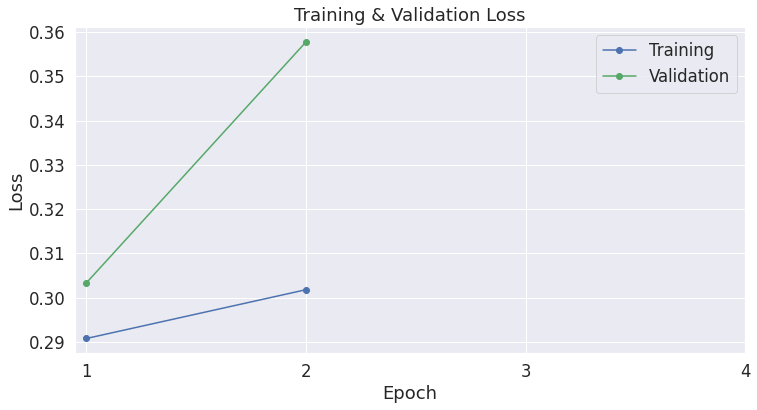

In [ ]:
#Plot the results from the Dataframe

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Step 8: Prep Dev Set


In [ ]:
import pandas as pd

#import Dev set. 
dev_df = pd.read_csv('dev_AB4.csv')
#the empty choice is converted to a NaN when I reload, so this will correct the issue.
dev_df['a'].fillna("", inplace=True)

print('Number of dev sentences: {:,}\n'.format(dev_df.shape[0]))

Number of dev sentences: 11,873



In [ ]:
#pull out the relevant columns.

contexts = dev_df.context.values
questions = dev_df.question.values
choices = dev_df[['a','b']].values
#now converted to an INT
dev_df.correct_index = dev_df.correct_index.fillna(0)
labels = dev_df.correct_index.astype(int).values

In [ ]:
input_ids = []
attention_masks = []
choices_features = []

#---- THIS IS THE LOOP TO COMBINE THE QUESTIONS WITH THE CHOICES ----
for i in range(len(questions)):
    row = list(choices[i])
    q_text = str(questions[i])+' '+str(contexts[i])
    temp_list = []
    for choice in row:
      text = (str(choice))
      temp_list.append(text)

    encoded_dict = tokenizer(
                        [q_text,q_text],
                        temp_list,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 384,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',
                        truncation = True)

# #Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
#input_ids = torch.cat(input_ids, dim=0)
input_ids = torch.stack(input_ids)
attention_masks = torch.stack(attention_masks)
labels = torch.tensor(labels).long()

In [ ]:
#Check the shape to make sure it worked correctly. 
print(input_ids.size(0))
print(attention_masks.size(0))
print(labels.size(0))

11873
11873
11873


In [ ]:
# Set the batch size.  
batch_size = 2  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Step 9: Evaluate Dev Set


In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 11,873 test sentences...
    DONE.


In [ ]:
def get_label_list(predictions):
  full_label_list = []
  for i in range(len(predictions)):
    for j in range(len(predictions[i])):
      full_label_list.append((np.argmax(predictions[i], axis=1).flatten())[j])
  return full_label_list

def get_pred_dict(full_labels, df):
    pred_dict = {}
    for i in range(len(full_labels)):
        key = str(dev_df['id'][i])
        best_guess = str(df.iloc[i, full_labels[i]])
        pred_dict[key] = best_guess
    return pred_dict 

#Output dict into a csv.
def output_predictions(pred_dict, file_name):
    with open(file_name, 'w', encoding = 'utf-8') as json_file:
        json.dump(pred_dict, json_file, ensure_ascii=True)

In [ ]:
import json

full_labels = get_label_list(predictions)
choice_df = dev_df[['a','b']]
preds = get_pred_dict(full_labels, choice_df)
output_predictions(preds, 'preds_AB.json')

In [ ]:
# save a copy in my drive.

%cp -R /content/preds_AB.json /content/drive/My\ Drive/model_save 

In [ ]:
# Clone SQUAD repo for the evaluation file.
# Move the eval file to my content folder 

!git clone https://github.com/white127/SQUAD-2.0-bidaf.git
%mv /content/SQUAD-2.0-bidaf/evaluate-v2.0.py /content/

Cloning into 'SQUAD-2.0-bidaf'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 709.51 KiB | 13.91 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
# Still download the Dev set.
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2020-07-22 00:34:10--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.109.153, 185.199.110.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       100%[===================>]   4.17M  21.6MB/s    in 0.2s    

2020-07-22 00:34:10 (21.6 MB/s) - ‘dev-v2.0.json’ saved [4370528/4370528]



In [ ]:
print("Results for AB, with 2 way Mutli Choice")
!python evaluate-v2.0.py dev-v2.0.json preds_AB.json


Results for AB, with 2 way Mutli Choice
{
  "exact": 63.766529099637836,
  "f1": 67.42261166125509,
  "total": 11873,
  "HasAns_exact": 75.67476383265857,
  "HasAns_f1": 82.9974136730904,
  "HasAns_total": 5928,
  "NoAns_exact": 51.892346509671995,
  "NoAns_f1": 51.892346509671995,
  "NoAns_total": 5945
}


### Step 10: Save Fine-Tuned Model 

In [ ]:
##### MAKE SURE YOU MOVE A COPY TO YOUR BUCKET.

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/My Drive/AB_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
torch.save(model.state_dict(), '/content/drive/My Drive/AB_save/model_state_dict.pth')

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/My Drive/AB_save/
